# Clustering

### Import common libraries

In [1]:
# Mount Google Drive and change directory 
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/ColabNotebooks/SACAC-EDA test/solutions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display format: two decimals
pd.options.display.float_format = '{:,.2f}'.format

## Introduction to clustering on "moons" dataset

We will explore the concepts of clustering using the moons dataset introduced in the dimensionality reduction section. Here, we import the dataset and immediately standardize the data and store it in an array `X`.

In [3]:
from sklearn.preprocessing import StandardScaler

# Import and scale data so that each feature has unit variance
df_moons = pd.read_csv('../data/moons_dataset.csv')
X = StandardScaler().fit_transform(df_moons)

### K-means clustering

The first clustering algorithm we will consider is *k-means clustering*, which we import from `sklearn.cluster.KMeans`. We create a `kmeans` object from the `KMeans` class, and fit the object to the data in `X`. For k-means clustering, the number of clusters is a parameter that we must specify upfront, when we first define the object. We will start with `n_clusters = 2`.

The k-means algorithm assigns a class label to each data point. The class labels are stored in the `kmeans.labels_` attribute: an array with as many entries as there are observations in the dataset, with each entry representing the class label of the corresponding data point. We can use the class labels to color the data points in a scatter plot, as shown below.

The `KMeans` class includes a few additional attributes, see the [scikit-learn API reference](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans) for details. An interesting one for our purposes is the `cluster_centers_`, which shows the center of each cluster. We will plot these as well to illustrate the clustering method.

c:\Users\tmlouw\Anaconda3\envs\py3_11\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'KMeans with 2 clusters')

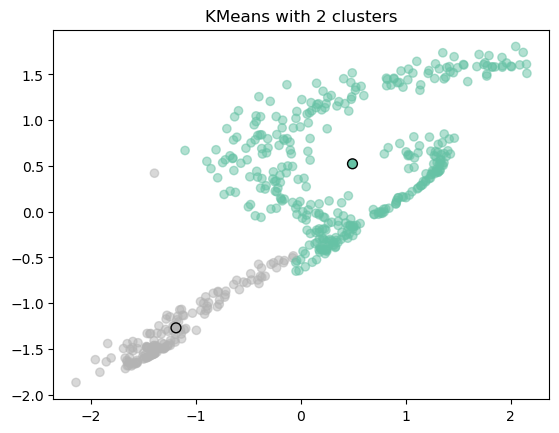

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)   # Create the kmeans object
kmeans.fit(X)   # Fit the kmeans object to the data

plt.scatter(X[:,0], X[:,1], alpha=0.5, c=kmeans.labels_, cmap = 'Set2') # Plot the data colored by cluster
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 50, 
            c=range(kmeans.cluster_centers_.shape[0]), cmap = 'Set2', edgecolors = 'k') # Mark the cluster centers
plt.title('KMeans with 2 clusters')

Try running the code above for different `n_clusters` to see the effects.

### DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) is an alternative clustering approach implemented using `sklearn.cluster.DBSCAN`. Like `KMeans`, we need to specify parameters upfront: in this case, the mininum number of samples per cluster `min_samples`, and the maximum distance between two samples in a neighbourhood `eps`. 

DBSCAN can also be used for outlier detection: if a sample, or a group of samples fewer than `min_samples` are not within a distance `eps` of any identified cluster, they are classified as outliers. The `dbscan.labels_` attribute will assign a value of -1 to all outliers. It is useful to plot the outliers separately from the clustered data points, hence the extra code below.

Text(0.5, 1.0, 'DBSCAN with eps = 0.2, min_samples = 5')

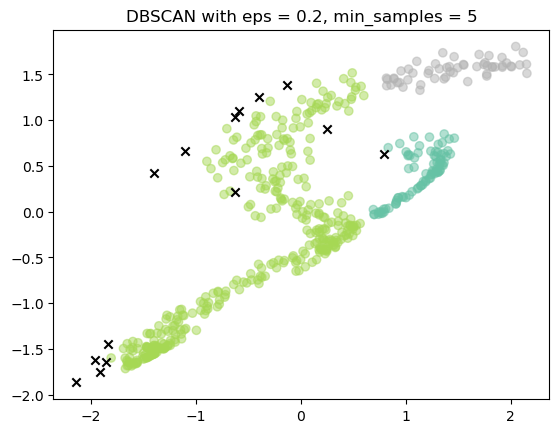

In [5]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.2, min_samples= 5)  # Create the DBSCAN object
dbscan.fit(X)   # Fit the DBSCAN object to the data

# Separate the clustered data from the outliers
X_clustered = X[dbscan.labels_!=-1, :]
X_outliers = X[dbscan.labels_== -1, :]

# Plot the clustered data and the outliers
plt.scatter(X_clustered[:,0], X_clustered[:,1], alpha=0.5,  c = dbscan.labels_[dbscan.labels_!=-1], cmap='Set2')
plt.scatter(X_outliers[:,0], X_outliers[:,1], c='black', marker = 'x')
plt.title('DBSCAN with eps = 0.2, min_samples = 5')

The method is quite sensitive to the neighbourhood size, `eps`. The code below attempts to illustrate the role of `eps` by plotting the neighbourhood around each core sample. Try changing the value of `eps` to see how this affects the DBSCAN clustering. But remember, you are viewing a 3D data set in two dimensions!

*Note on the code*: to plot the radius `eps`, we make use of the fact that plt.scatter allows us to specify the size of a marker using the keyword argument `s`. However, the size specified is the number of points on the graph, squared. We therefore need to transform the radius of the neighbourhood `eps` to a length in points on the graph, which just requires a few extra lines of code.

Text(0.5, 1.0, 'DBSCAN with eps = 0.1, min_samples = 5')

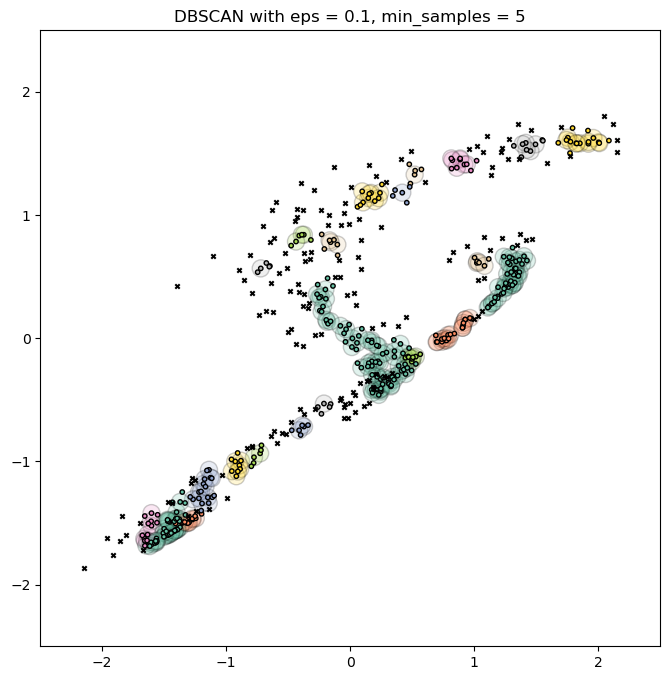

In [6]:
eps = 0.1   # Set the maximum distance between two samples for one to be considered as in the neighborhood of the other
dbscan = DBSCAN(eps = eps, min_samples= 5) # Create the DBSCAN object
dbscan.fit(X) # Fit the DBSCAN object to the data

# Separate the clustered data from the outliers, and the core samples
X_clustered = X[dbscan.labels_!=-1, :]
X_outliers = X[dbscan.labels_== -1, :]
X_core = X[dbscan.core_sample_indices_, :]

# Create the figure and set the axis limits
fig,ax = plt.subplots(figsize=(8,8))  
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)

# Find the length of a line in "points", if the line has length eps in data coordinates
disk = ax.transData.transform([[0, 0,], [0, eps]])
r =  disk[1,1] - disk[0,1]

# Plot the core samples with size eps**2, the clustered data, and the outliers
ax.scatter(X_core[:,0], X_core[:,1], alpha=0.2,  s = r**2, c = dbscan.labels_[dbscan.core_sample_indices_], cmap='Set2',linewidths=1, edgecolors=  'black')
ax.scatter(X_clustered[:,0], X_clustered[:,1], alpha=1, s = 10, c = dbscan.labels_[dbscan.labels_!=-1], cmap='Set2', edgecolors=  'black')
ax.scatter(X_outliers[:,0], X_outliers[:,1], s = 10, c='black', marker = 'x')
ax.set_title('DBSCAN with eps = 0.1, min_samples = 5')

As mentioned in the dimensionality reduction section, there are many different non-linear methods. One method that seems to identify structure in the moons data quite well is the "Locallly Linear Embedding" (LLE) method, implemented as `sklearn.manifold.LocallyLinearEmbedding`. Using this method, we transform our original data `X` to a two-dimensional latent variable space; the data in the latent variable space is contained in array `L`. This is very similar to our use of t-SNE, just using a different learning algorith.

Notice that, like t-SNE, LLE is randomly initialised. If you run the cell below multiple times, you end up with slightly different latent variables.

Text(0.5, 1.0, 'Locally Linear Embedding of moons data')

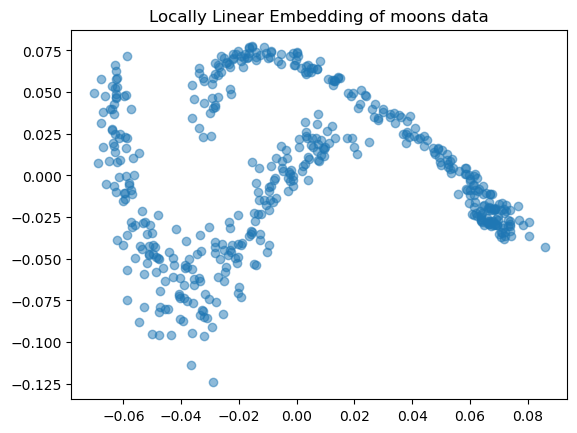

In [7]:
from sklearn.manifold import LocallyLinearEmbedding as LLE
lle = LLE(n_neighbors = 50) # Create the LLE object
L = lle.fit_transform(X) # Fit the LLE object to the data
plt.scatter(L[:,0], L[:,1], alpha= 0.5)
plt.title('Locally Linear Embedding of moons data')

We will now use both k-means and DBSCAN to cluster the dataset. We expect DBSCAN to outperform k-means given the nature of the dataset (highly non-convex). We add extra code to show the cluster centers and core point neighbourhoods in each case.

Notice a different value of `eps` is required due to the scale of the latent variable space.

c:\Users\tmlouw\Anaconda3\envs\py3_11\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'DBSCAN clustering with eps = 0.01, min_samples = 5')

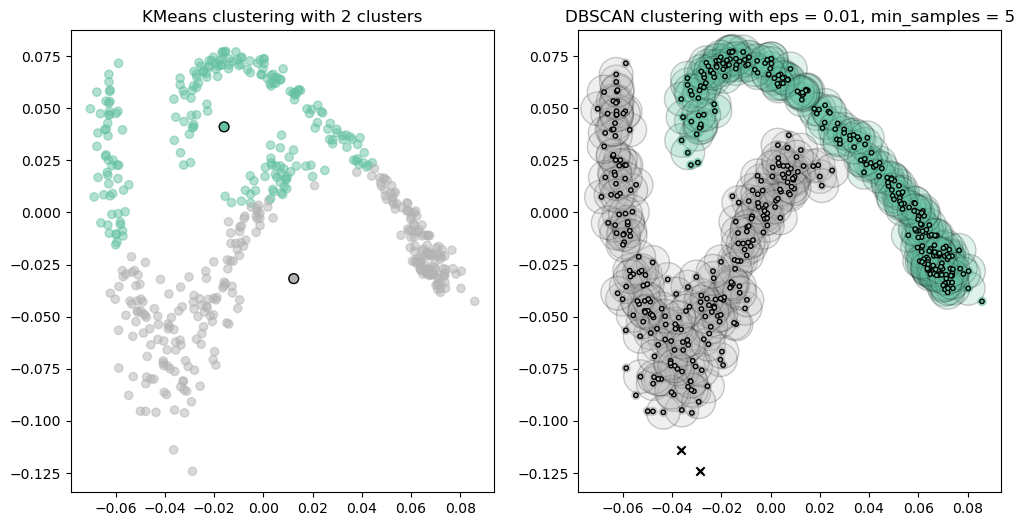

In [8]:
# Define and fit k-means to latent variables
kmeans = KMeans(n_clusters=2)
kmeans.fit(L)

# Define and fit DBSCAN to latent variables
eps = 0.01
dbscan = DBSCAN(eps = eps, min_samples= 5)
dbscan.fit(L)

# Separate the clustered data from the outliers
L_clustered = L[dbscan.labels_!=-1, :]
L_outliers = L[dbscan.labels_== -1, :]

# Plot k-means and DBSCAN clustering results side by side
fig,ax= plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(L[:,0], L[:,1], alpha=0.5, c=kmeans.labels_, cmap = 'Set2')
ax[1].scatter(L_clustered[:,0], L_clustered[:,1], alpha=0.5,  c = dbscan.labels_[dbscan.labels_!=-1], cmap='Set2')
ax[1].scatter(L_outliers[:,0], L_outliers[:,1], c='black', marker = 'x')

# The code below is added to illustrate the methods and not required in practice
# Add cluster centers
ax[0].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 50, 
            c=range(kmeans.cluster_centers_.shape[0]), cmap = 'Set2', edgecolors = 'k') # Mark the cluster centers
ax[0].set_title('KMeans clustering with 2 clusters')

# Add core-point neighbourhoods
# Find the length of a line in "points", if the line has length eps in data coordinates
disk = ax[1].transData.transform([[0, 0,], [0, eps]])
r =  disk[1,1] - disk[0,1]

# Plot the core samples with size eps**2, the clustered data, and the outliers
L_core = L[dbscan.core_sample_indices_, :]
ax[1].scatter(L_core[:,0], L_core[:,1], alpha=0.2,  s = r**2, c = dbscan.labels_[dbscan.core_sample_indices_], cmap='Set2',linewidths=1, edgecolors=  'black')
ax[1].scatter(L_clustered[:,0], L_clustered[:,1], alpha=1, s = 10, c = dbscan.labels_[dbscan.labels_!=-1], cmap='Set2', edgecolors=  'black')
ax[1].scatter(L_outliers[:,0], L_outliers[:,1], s = 10, c='black', marker = 'x')
ax[1].set_title('DBSCAN clustering with eps = 0.01, min_samples = 5')


## Clustering metrics
Clustering is an unsupervised method, which makes it difficult to quantify the "quality" of the clusters identified. Scikit-learn includes a variety of clustering quality metrics, but many of them require the ground truth (i.e., true cluster labels) to be known, which is most often not the case in EDA. Three metrics are available which do not require the ground truth: the silhouette score `sklearn.metrics.silhouette_score`, the Calinski-Harabasz score `sklearn.metrics.calinski_harabasz_score` and the Davies-Bouldin score `metrics.davies_bouldin_score`. All three methods have different benefits and drawbacks. For more details, including mathematical formulation and links to the original research, see the [scikit-learn clustering tutorial](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

Based on the graphs above, it seems quite clear that DBSCAN outperforms k-means. However, k-means has the highest silhouette score and Calinski-Harabasz score, whereas DBSCAN outperfroms k-means in terms of the Davies-Bouldin score. This serves as further evidence that clustering metrics should be be used with caution. Often, clustering is more about helping you see the data in a new way, rather than maximizing some score.

In [9]:
# Compute the silhouette score, Calinski-Harabasz score, and Davies-Bouldin score for k-means and DBSCAN clustering
from sklearn import metrics
print(f"Silhouette score for k-means clustering: {metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'):.3f}")
print(f"Silhouette score for DBSCAN clustering: {metrics.silhouette_score(X, dbscan.labels_, metric='euclidean'):.3f}")

print(f"Calinski-Harabasz score for k-means clustering: {metrics.calinski_harabasz_score(X, kmeans.labels_):.3f}")
print(f"Calinski-Harabasz score for DBSCAN clustering: {metrics.calinski_harabasz_score(X, dbscan.labels_):.3f}")

print(f"Davies-Bouldin score for k-means clustering: {metrics.davies_bouldin_score(X, kmeans.labels_):.3f}")
print(f"Davies-Bouldin score for DBSCAN clustering: {metrics.davies_bouldin_score(X, dbscan.labels_):.3f}")

Silhouette score for k-means clustering: 0.254
Silhouette score for DBSCAN clustering: 0.080
Calinski-Harabasz score for k-means clustering: 246.913
Calinski-Harabasz score for DBSCAN clustering: 89.546
Davies-Bouldin score for k-means clustering: 1.278
Davies-Bouldin score for DBSCAN clustering: 1.400


## Clustering on iron ore flotation data

### Performing k-means clustering and DBSCAN on the data

We will now perform clustering on the iron ore flotation data. Recall from the dimensionality reduction section that ten principal components were required to account for >90% of the variance. We will therefore perform clustering on the first ten principal components, and visualise the results using t-SNE.

First we load the data and standardize the data (dropping the product composition as before) to give an array `X`. We then perform principal component analysis, retaining ten components in the scores array `T`, then learn a two-dimensional latent variable array `L`, which we may use for visualisation.

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 10)
tsne = TSNE()

df_concentrator = pd.read_csv('../data/open_iof_cleaned_dataset.csv', index_col='date', parse_dates=['date'])
df_concentrator = df_concentrator.resample('4h').median()
df_concentrator.dropna(inplace=True)

X = StandardScaler().fit_transform(df_concentrator.drop(['y product iron %', 'y product silica %'], axis = 1))
T = pca.fit_transform(X)
L = tsne.fit_transform(T)

In the code below, we will use k-means clustering as well as DBSCAN.  Try different values for `n_clusters`, `eps` and `min_samples`, until you find a combination that seems reasonable.

Remember, t-SNE is a non-linear method and does not conserve distance in a linear way. Clusters that might be "close" in the ten dimensional space could be a bit further away in the two-dimensional representation. You can try different manifold learning methods (e.g., `Isomap` or `LocallyLinearEmbedding`) for different visualisations without affecting the clustering itself (which is performed on the first ten principal components, not the latent representations).

c:\Users\tmlouw\Anaconda3\envs\py3_11\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Silhouette score for k-means clustering: 0.186
Silhouette score for DBSCAN clustering: 0.065
Calinski-Harabasz score for k-means clustering: 123.798
Calinski-Harabasz score for DBSCAN clustering: 23.953
Davies-Bouldin score for k-means clustering: 1.680
Davies-Bouldin score for DBSCAN clustering: 1.659


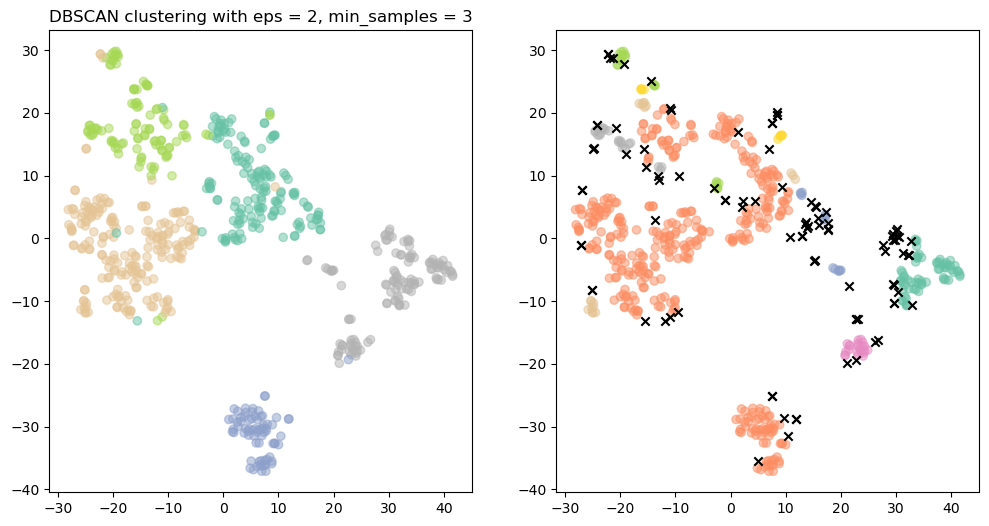

In [11]:
# Perform k-means clustering on the principal components in T
kmeans = KMeans(n_clusters=5)
kmeans.fit(T)

# Perform DBSCAN  on the principal components in T, and split the latent variable L into clustered and outlier data
dbscan = DBSCAN(eps = 2, min_samples= 3)
dbscan.fit(T)
L_clustered = L[dbscan.labels_!=-1, :]
L_outliers = L[dbscan.labels_== -1, :]

# Plot k-means and DBSCAN clustering results side by side
fig,ax= plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(L[:,0], L[:,1], alpha=0.5, c=kmeans.labels_, cmap = 'Set2')
ax[0].set_title('KMeans clustering with 5 clusters')
ax[1].scatter(L_clustered[:,0], L_clustered[:,1], alpha=0.5,  c = dbscan.labels_[dbscan.labels_!=-1], cmap='Set2')
ax[1].scatter(L_outliers[:,0], L_outliers[:,1], c='black', marker = 'x')
ax[0].set_title('DBSCAN clustering with eps = 2, min_samples = 3')

# Calculate the silhouette, Calinski-Harabasz, and Davies-Bouldin scores for k-means and DBSCAN clustering
print(f"Silhouette score for k-means clustering: {metrics.silhouette_score(T, kmeans.labels_, metric='euclidean'):.3f}")
print(f"Silhouette score for DBSCAN clustering: {metrics.silhouette_score(T, dbscan.labels_, metric='euclidean'):.3f}")

print(f"Calinski-Harabasz score for k-means clustering: {metrics.calinski_harabasz_score(T, kmeans.labels_):.3f}")
print(f"Calinski-Harabasz score for DBSCAN clustering: {metrics.calinski_harabasz_score(T, dbscan.labels_):.3f}")

print(f"Davies-Bouldin score for k-means clustering: {metrics.davies_bouldin_score(T, kmeans.labels_):.3f}")
print(f"Davies-Bouldin score for DBSCAN clustering: {metrics.davies_bouldin_score(T, dbscan.labels_):.3f}")

### Visualising the clusters on the time-series plots

The k-means algorithm with five clusters seem to give reasonable results. Let us visualise the identified clusters by plotting the time series data for selected variables, and colouring it according to cluster labels.

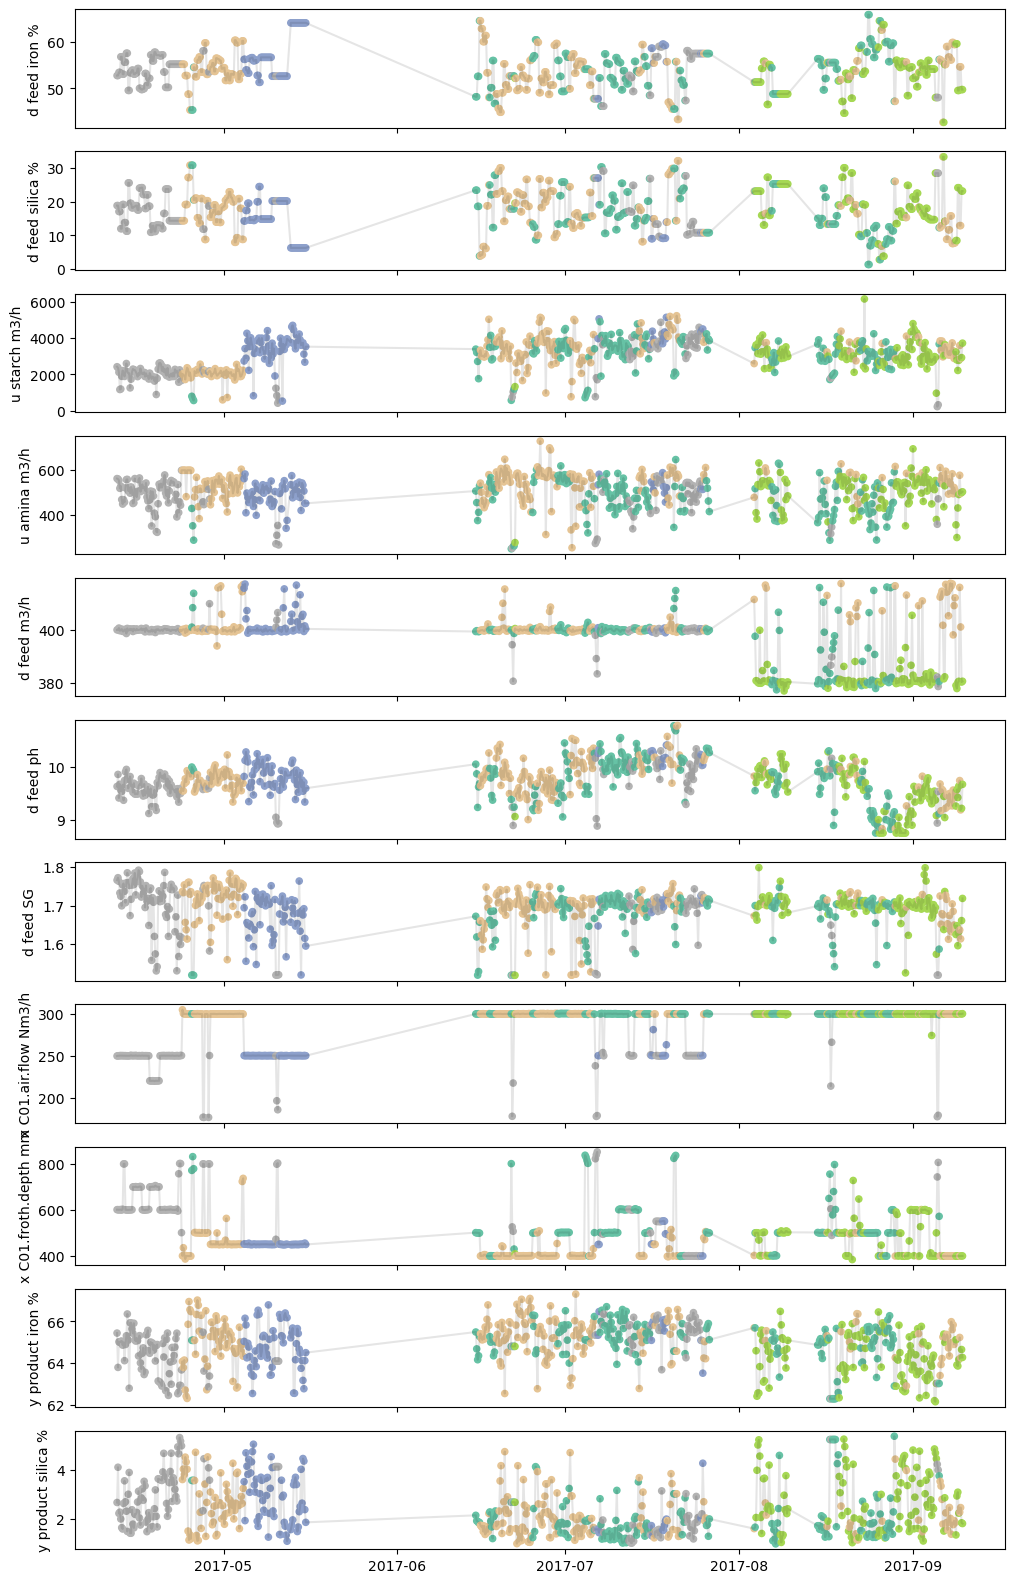

In [13]:
# Select a subset of features to visualize
selected = ['d feed iron %', 'd feed silica %', 'u starch m3/h', 'u amina m3/h',
       'd feed m3/h', 'd feed ph', 'd feed SG', 'x C01.air.flow Nm3/h',
       'x C01.froth.depth mm', 'y product iron %', 'y product silica %']

fig,ax = plt.subplots(len(selected), 1, figsize=(12,20), sharex= True)
for (i, col) in enumerate(selected):
    ax[i].plot(df_concentrator.index, df_concentrator[col], 'k', alpha = 0.1)       # Line plot of features
    ax[i].scatter(df_concentrator.index, df_concentrator[col], s = 5, c=kmeans.labels_, cmap = 'Set2') # Scatter plot of features colored by cluster
    ax[i].set_ylabel(col)
